In [35]:
import numpy as np
import astropy.units as u
from astropy.io import fits

from gmagaox.math_module import xp, _scipy, ensure_np_array
import gmagaox.gmagaox as gmagaox
from gmagaox import optics, opds
from gmagaox import utils
from gmagaox.imshows import *

from importlib import reload

import poppy

import logging
import sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False
poppy_log.disabled = True

zemax_pupil_diams = {
    'fsm-pp':16.1887*u.mm,
    'ADC-pp':50.3325*u.mm, 
    'woofer-pp':87.6977*u.mm, 
    'tweeter-pp':73.7536*u.mm, 
    'focal plane SM - pp':12.1121*u.mm, 
    'Apodizer-pp':24.2002*u.mm, 
    'Lyot-pp':25.1939*u.mm, 
}


In [1]:
!nvidia-smi

Thu Feb 22 20:02:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:25:00.0 Off |                    0 |
| N/A   35C    P0               44W / 300W|      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [36]:
reload(optics)
reload(opds)
reload(gmagaox)

npix = 800
oversample = 4
# opds.SCREEN_SIZE = int(npix*oversample)

model = gmagaox.MODEL(npix=npix, oversample=oversample)
model.use_opds = True
# model.ideal_coro = True

wfs = model.calc_wfs()

# scicam_wf = model.calc_wf()
# imshow1(xp.abs(scicam_wf)**2, lognorm=True, npix=100)

Propagating wavelength 633.000 nm.
PSF calculated in 0.862s


Correction distance: 0.00000000 mm


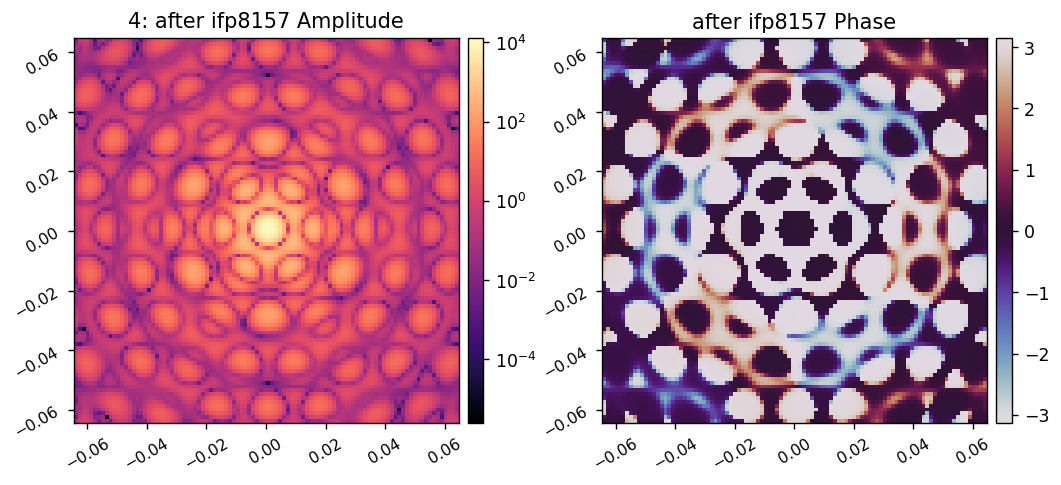

Pupil Diameter: 15.953181514491458 mm
	Percent Error = -1.45


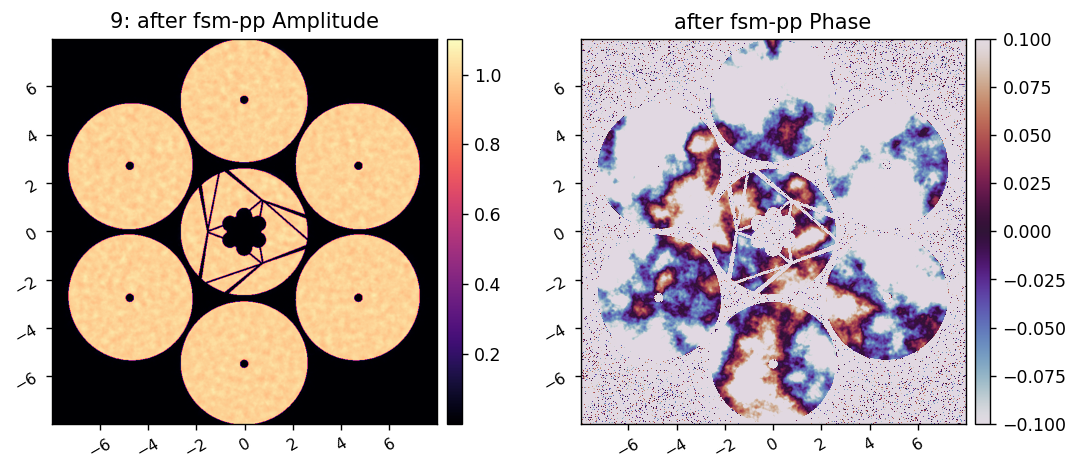

Correction distance: 0.00000000 mm


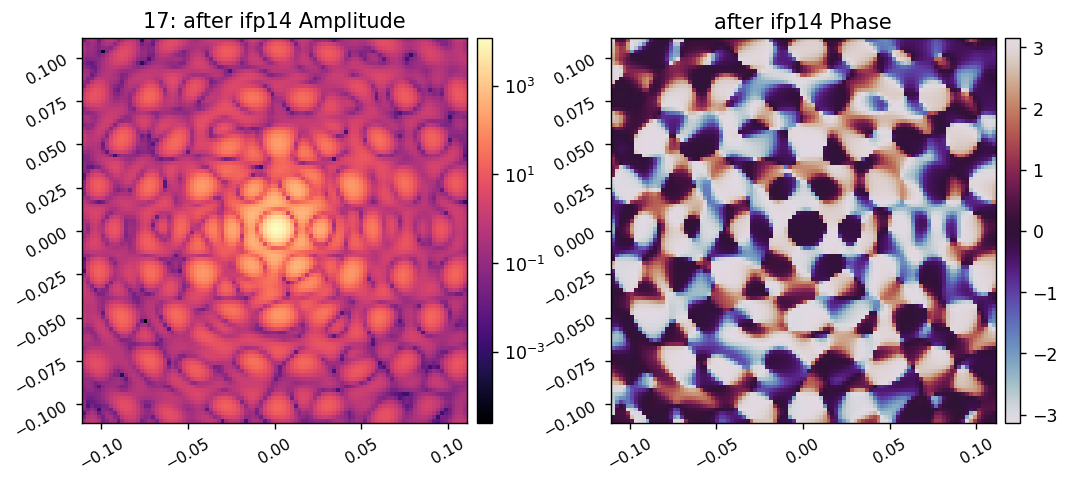

Pupil Diameter: 49.90333224672819 mm
	Percent Error = -0.85


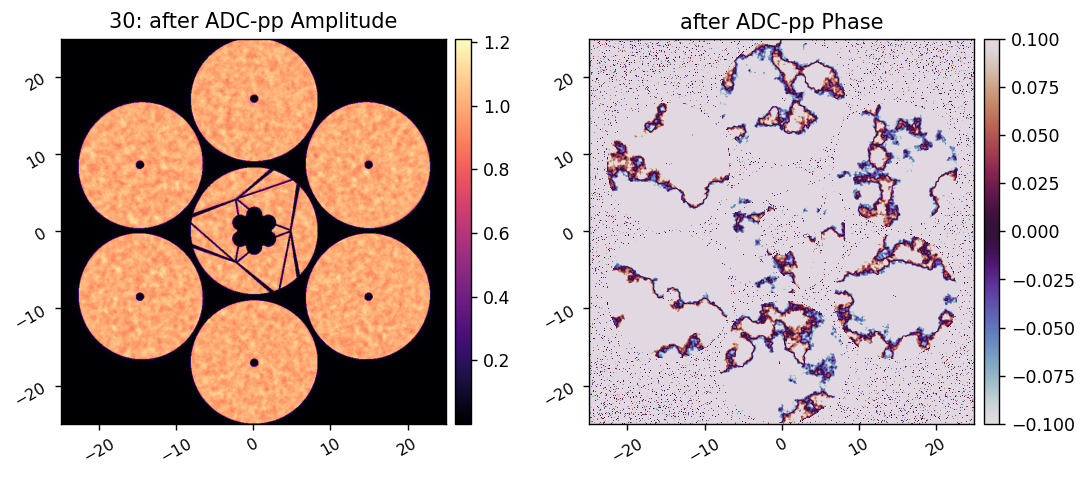

Correction distance: 0.00000000 mm


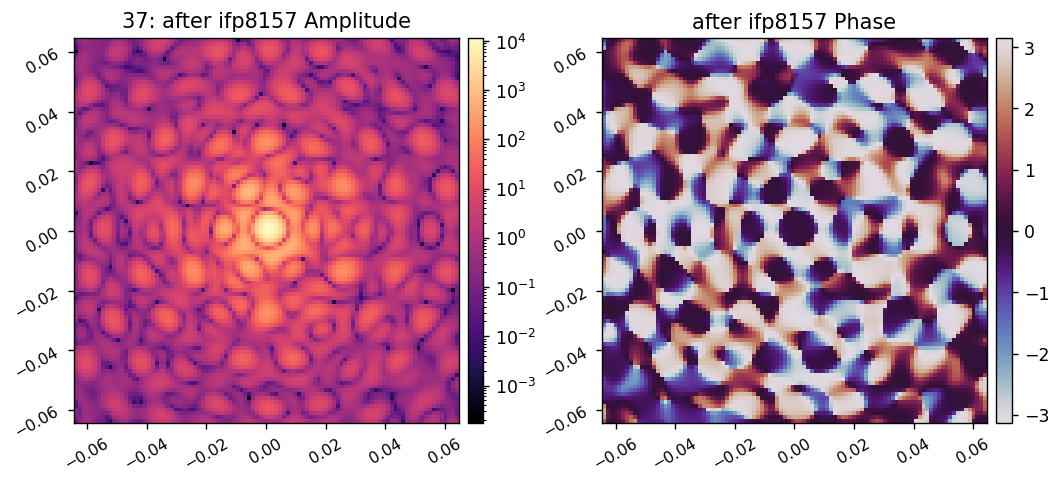

Pupil Diameter: 86.4324017465818 mm
	Percent Error = -1.44


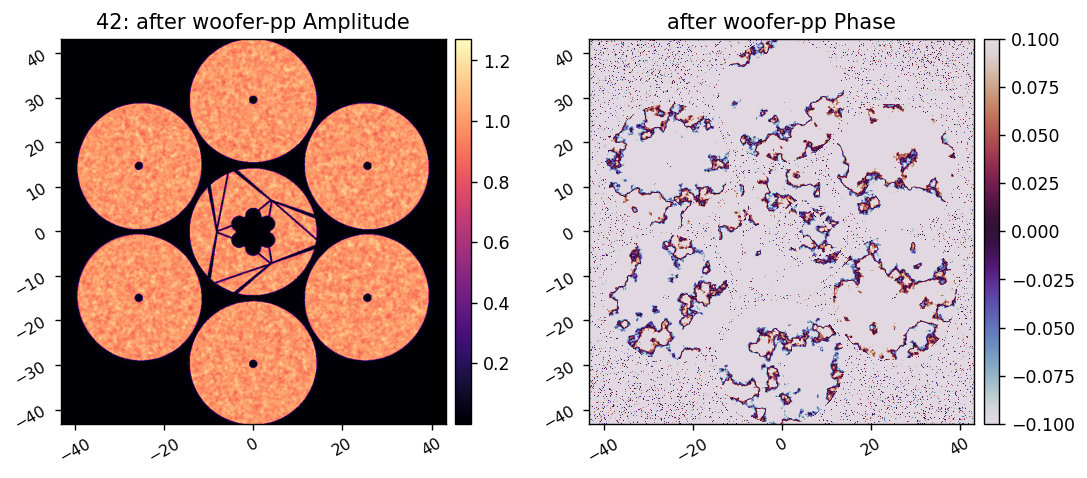

Correction distance: 0.00000139 mm


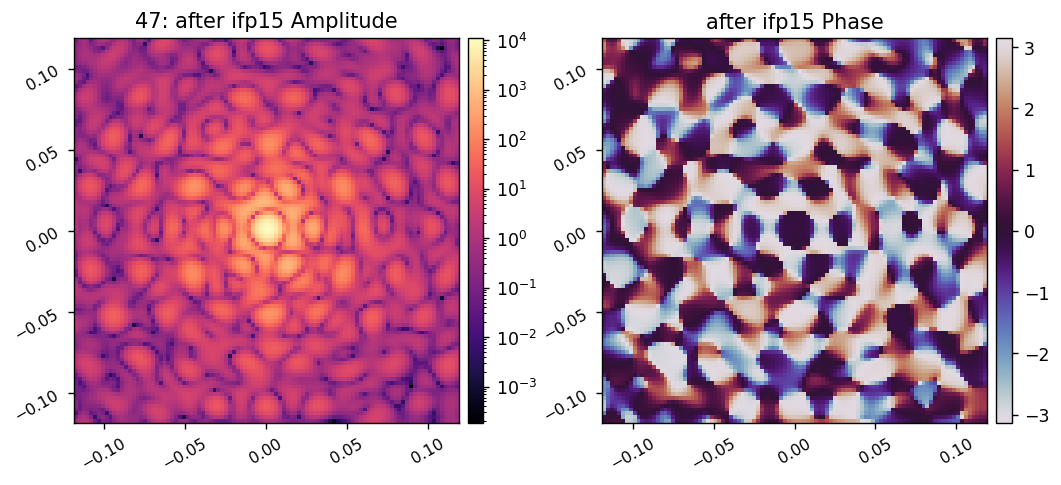

Pupil Diameter: 72.88629845263033 mm
	Percent Error = -1.18


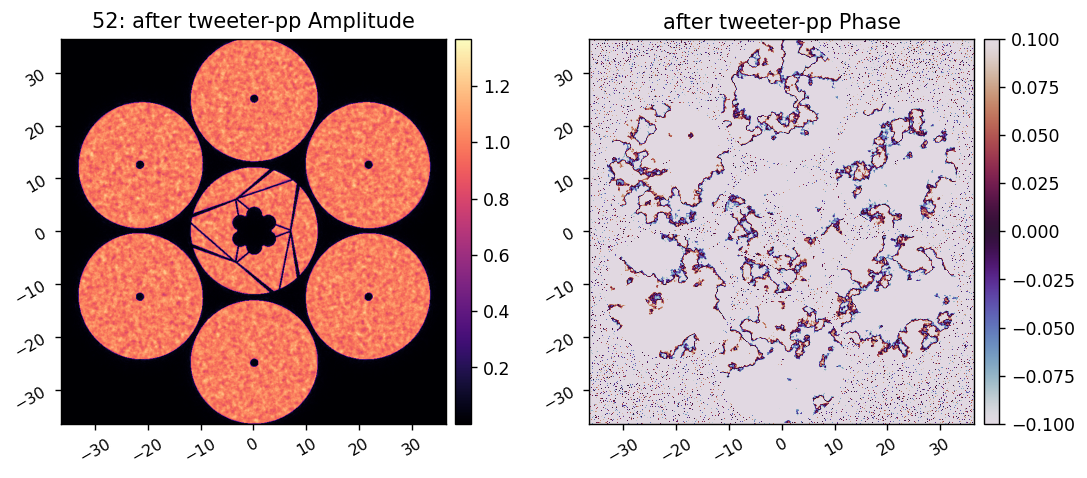

Correction distance: 0.00000164 mm


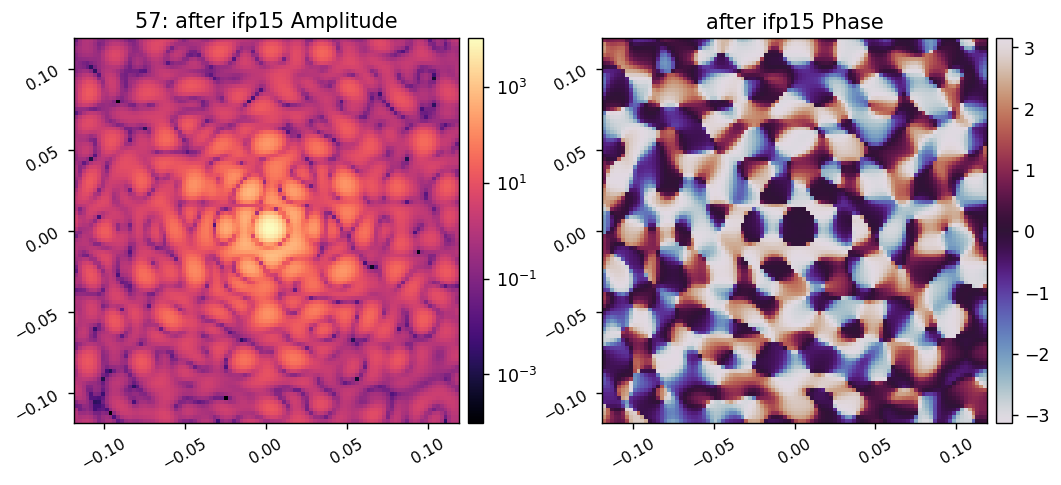

Pupil Diameter: 11.975771643522485 mm
	Percent Error = -1.13


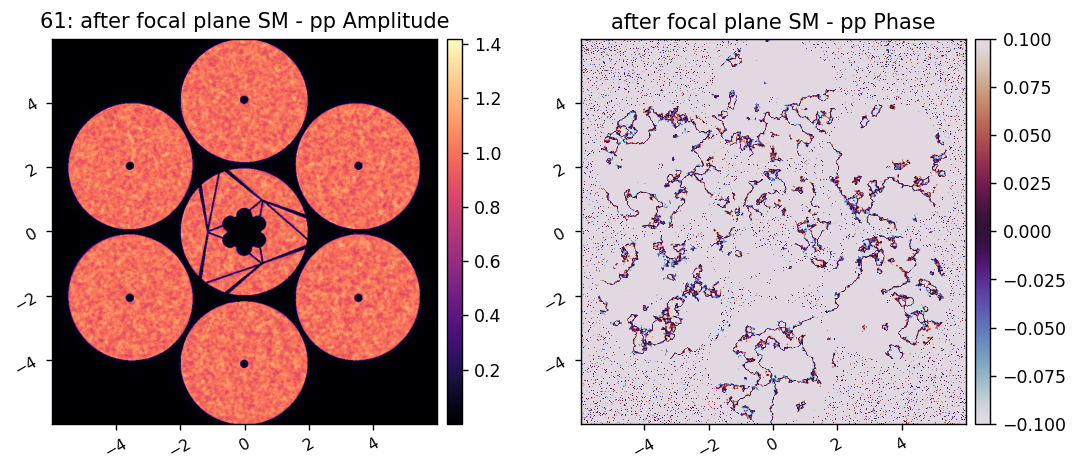

Correction distance: 0.00097557 mm


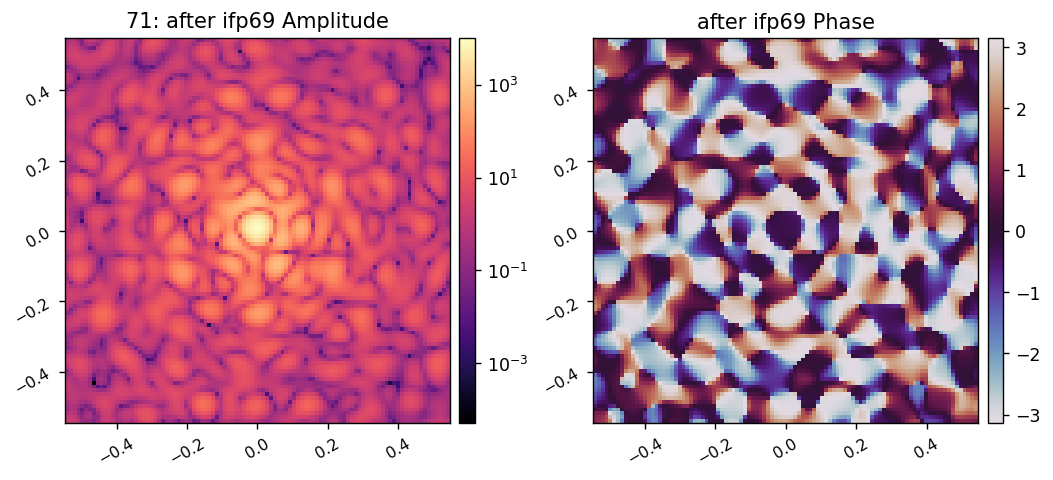

Pupil Diameter: 23.9511421127761 mm


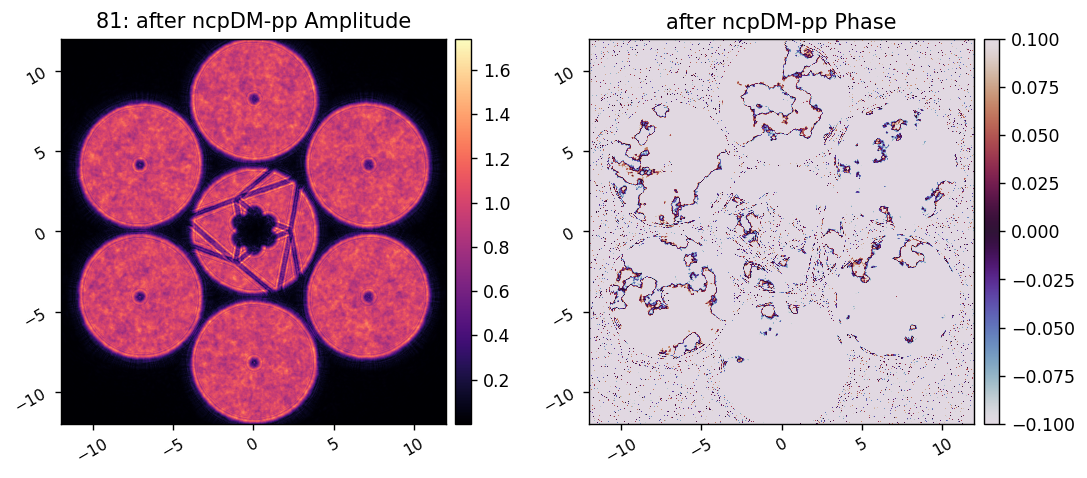

Pupil Diameter: 23.9511421127761 mm
	Percent Error = -1.03


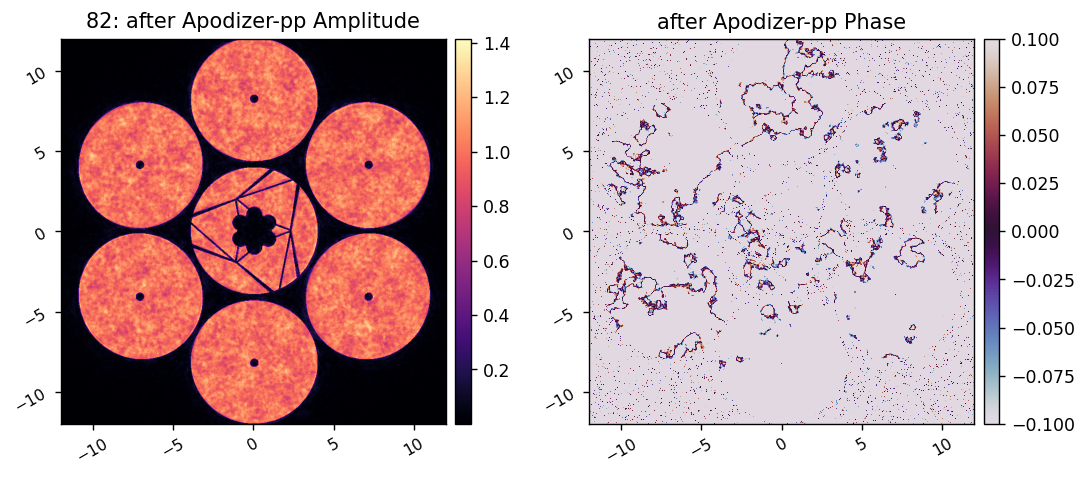

Correction distance: 0.00000000 mm


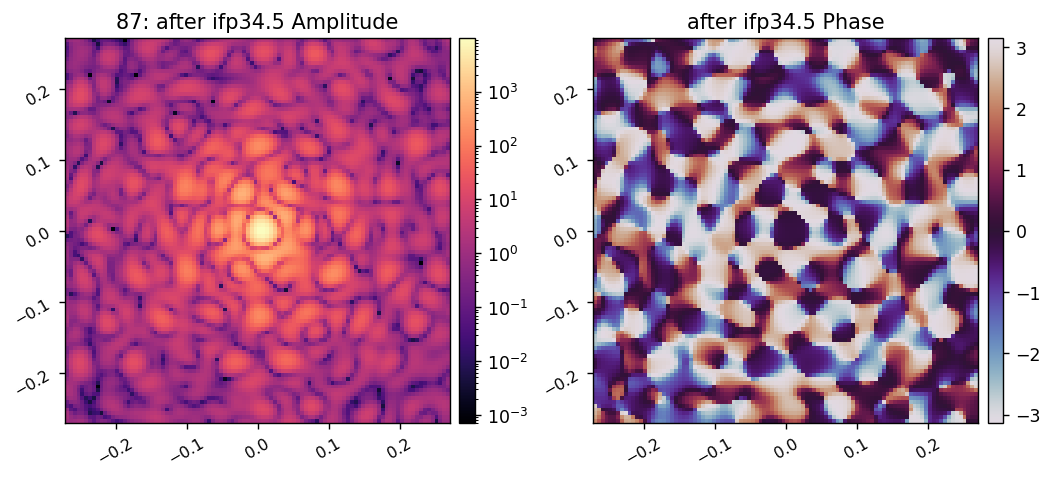

Pupil Diameter: 25.204568699355036 mm
	Percent Error = 0.04


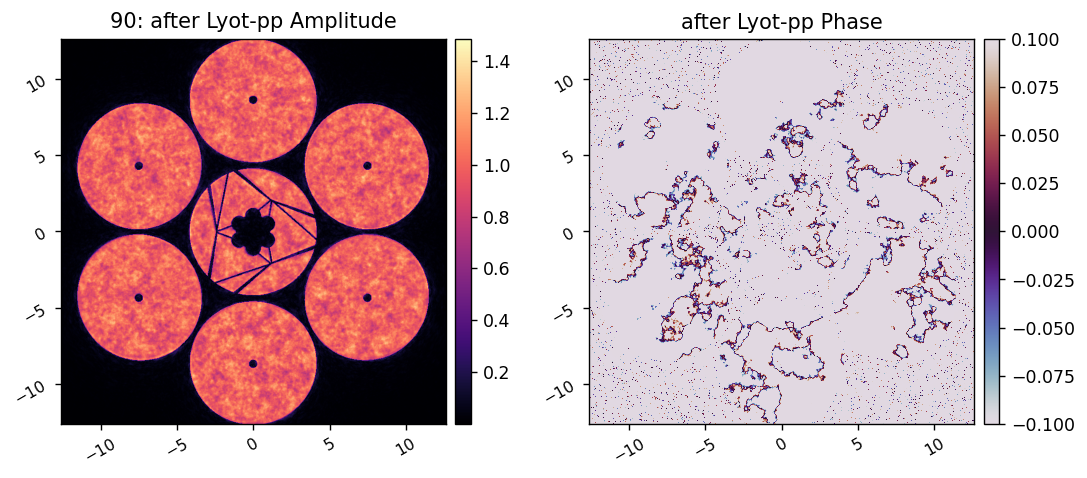

Correction distance: 0.00005643 mm


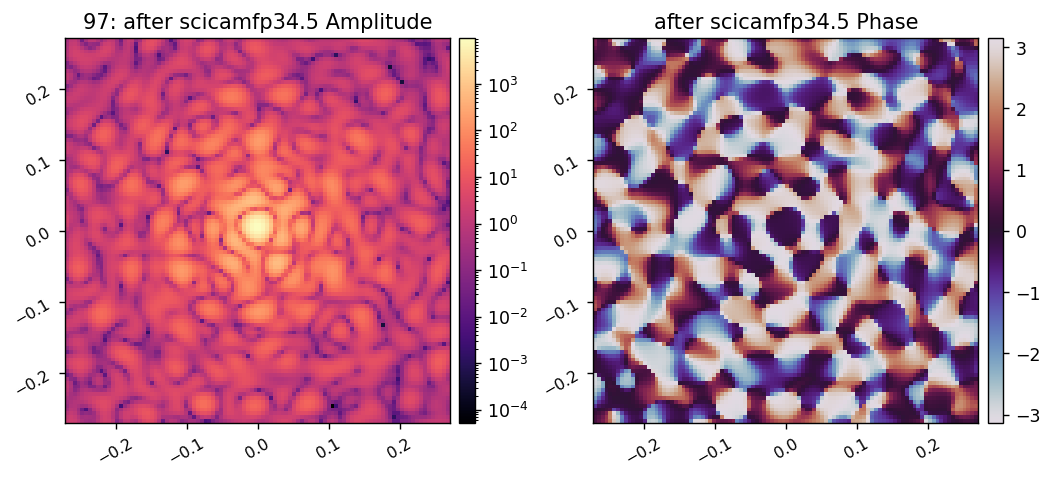

In [37]:
for i,wf in enumerate(wfs):
    if 'fp' in wf.location:
        print(f'Correction distance: {(wf.z_w0 - wf.z).to(u.mm):.8f}')
        npix = 100
        imshow2(wf.intensity, wf.phase, f'{i:d}: ' + wf.location + ' Amplitude', wf.location+' Phase',
                lognorm1=True,
                cmap2='twilight',
                npix=npix, pxscl=wf.pixelscale.to(u.mm/u.pix)
                )
    elif 'pp' in wf.location:
        diam = wf.pixelscale.to(u.mm/u.pix) * model.npix*u.pix
        print(f'Pupil Diameter: {diam}')
        if 'ncp' not in wf.location:
            pererr = 100 * (diam-zemax_pupil_diams[wf.location[6:]])/zemax_pupil_diams[wf.location[6:]]
            print(f'\tPercent Error = {pererr:.2f}')
        imshow2(wf.amplitude, wf.phase, f'{i:d}: ' + wf.location + ' Amplitude', wf.location+' Phase',
                cmap2='twilight',
                npix=model.npix, pxscl=wf.pixelscale.to(u.mm/u.pix),
                vmin2=-0.1, vmax2=0.1, 
                )
    # else:
    #     imshow2(wf.amplitude, wf.phase, f'{i:d}: ' + wf.location+' Amplitude', wf.location+' Phase',
    #             cmap2='twilight',
    #             npix=model.npix, pxscl=wf.pixelscale.to(u.mm/u.pix)
    #             )

In [8]:
(25.4/6.5)**2

15.270059171597632

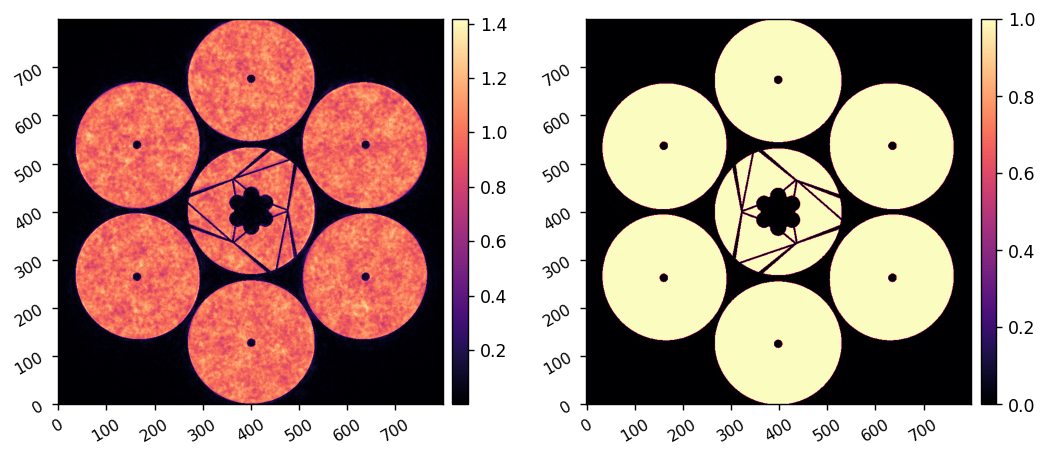

(288576.93939339876-75292.3360145835j) 359237.0


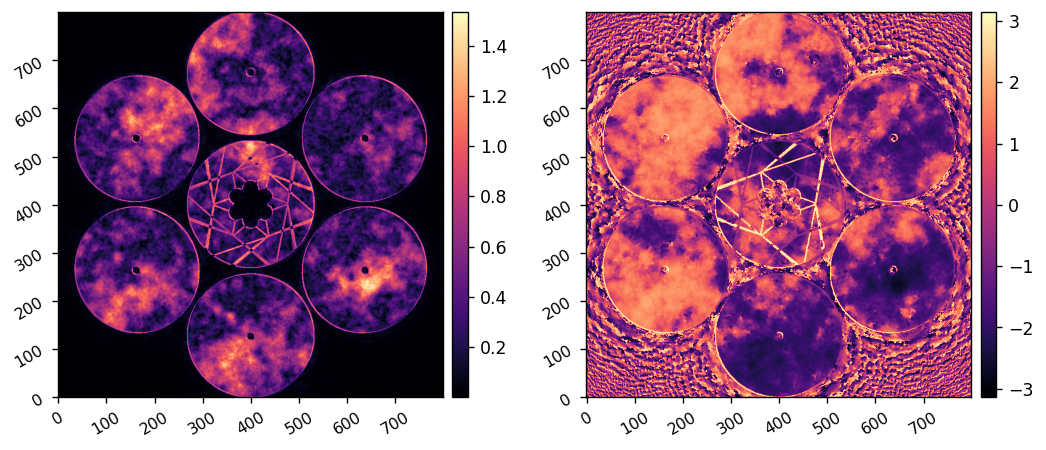

In [33]:
Iin = utils.pad_or_crop(wfs[82].wavefront, model.npix)
T = model.PUPIL.amplitude
imshow2(xp.abs(Iin), T)
numer = Iin.flatten().dot(T.flatten())
denom = T.flatten().dot(T.flatten())
print(numer, denom)

Icoro = Iin - T*numer/denom

imshow2(xp.abs(Icoro), xp.angle(Icoro))

apodizer = poppy.ArrayOpticalElement(transmission=xp.abs(Icoro), opd=xp.angle(Icoro)*model.wavelength.to_value(u.m)/(2*np.pi),
                                     pixelscale=wfs[82].pixelscale)

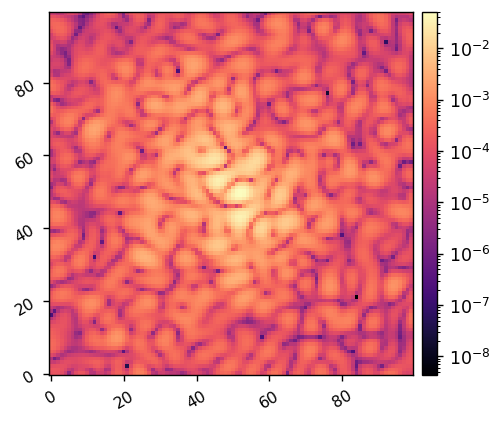

In [38]:
model.APODIZER = None
scicam_wf = model.calc_wf()

model.Imax_ref = xp.max(xp.abs(scicam_wf)**2)
model.APODIZER = apodizer
scicam_wf = model.calc_wf()

imshow1(xp.abs(scicam_wf)**2, lognorm=True, npix=100)
